## real yelp data with the camouflag pattern
## also injected with the ts and rating 

In [1]:
import os,sys
from tqdm import tqdm
from scipy.sparse import csc_matrix, coo_matrix, csr_matrix, lil_matrix
def myreadfile(fnm, mode):
    if '.gz' == fnm[-3:]:
        fnm = fnm[:-3]
    if os.path.isfile(fnm):
        f = open(fnm, mode)
    elif os.path.isfile(fnm+'.gz'):
        import gzip
        f = gzip.open(fnm+'.gz', mode)
    else:
        print('file: {} or its zip file does NOT exist'.format(fnm))
        sys.exit(1)
    return f

def saveSimpleListData(simls, outdata):
    with open(outdata, 'w') as fw:
        fw.write('\n'.join(map(str, simls)))
        fw.write('\n')
        fw.close()
        
def savesm2edgelist(sm, ofile, idstartzero=True, delimiter=' ', kformat=None):
    '''
    Save sparse matrix into edgelist
    kformat = "{0:.1f}"
    '''
    offset = 0 if idstartzero else 1
    lsm = sm.tolil()
    with open(ofile, 'wb') as fout:
        i = 0
        for row, d in zip(lsm.rows, lsm.data):
            for j,w in zip(row, d):
                if kformat is not None:
                    w = str.format(kformat, w)
                ostr = delimiter.join([str(i+offset), str(j+offset), str(w)])
                #fout.write('{} {} {}\n'.format(i+offset, j+offset, w))
                fout.write((ostr+'\n').encode())
            i+=1
        fout.close()
    return

def saveDictListData(dictls, outdata):
    with open(outdata, 'w') as fw:
        for k, l in dictls.items():
            if type(l) != list:
                print("This is not a dict of value list.\n")
                break
            fw.write("{}:".format(k))
            for i in range(len(l)-1):
                fw.write("{} ".format(l[i]))
            fw.write("{}\n".format(l[-1]))
        fw.close()
        
def loadDictListData(indata, edgeSet, ktype=str, vtype=str):
    dictls={}
    with myreadfile(indata, 'r') as fr:
        for line in tqdm(fr):
            line = line.strip().decode().split(':')
            lst=[]
            for e in line[1].strip().split(' '):
                lst.append(vtype(e))
            if(int(line[0].strip().split('-')[0]) in edgeSet and int(line[0].strip().split('-')[1]) in edgeSet):
                dictls[ktype(line[0].strip())]=lst
        fr.close()
    return dictls

def loadedge2sm(ifile, edge_set, mtype=csc_matrix, weighted=False, dtype=int, delimiter=',', issquared=False):
    '''
    load edge list into sparse matrix
    matrix dimensions are decided by max row id and max col id
    support csr, coo, csc matrix
    '''
    xs=[]
    ys=[]
    data=[]
    print(ifile)
    with myreadfile(ifile, 'rb') as fin:
        for line in tqdm(fin):
            line = line.decode().strip()
            coords=line.strip().split(' ')
            if(int(coords[0]) in edge_set and int(coords[1]) in edge_set):
                xs.append( int(coords[0]) )
                ys.append( int(coords[1]) )
                if weighted:
                    data.append(dtype(coords[2]))
                else:
                    data.append(1)
        fin.close()
    m = max(xs) + 1
    n = max(ys) + 1
    if issquared is False:
        M, N = m, n
    else:
        M = max(m,n)
        N = max(m,n)
        
    print("edge len", len(data))
    sm = mtype((data, (xs, ys)), shape=(M,N))
    return sm

In [2]:
import sys
import numpy as np
import random
import numpy.random as nr
import scipy.linalg as sla
from scipy.sparse import coo_matrix

def genEvenDenseBlock(A, B, p):
    m = []
    for i in range(A):
        a = np.random.binomial(1, p, B)
        m.append(a)
    return np.array(m)

def genHyperbolaDenseBlock(A, B, alpha, tau):
    'this is from hyperbolic paper: i^\alpha * j^\alpha > \tau'
    m = np.empty([A, B], dtype=int)
    for i in range(A):
        for j in range(B):
            if (i+1)**alpha * (j+1)**alpha > tau:
                m[i,j] = 1
            else:
                m[i,j] = 0
    return m

def genDiHyperRectBlocks(A1, B1, A2, B2, alpha=-0.5, tau=None, p=1):
    if tau is None:
        tau = A1**alpha * B1**alpha
    m1 = genEvenDenseBlock(A1, B1, p=p)
    m2 = genHyperbolaDenseBlock(A2, B2, alpha, tau)
    M = sla.block_diag(m1, m2)
    return M

def addnosie(M, A, B, p, black=True, A0=0, B0=0):
    v = 1 if black else 0
    for i in range(A-A0):
        a = np.random.binomial(1, p, B-B0)
        for j in a.nonzero()[0]:
            M[A0+i,B0+j]=v
    return M


def injectCliqueCamo(M, m0, n0, p, testIdx):
    (m,n) = M.shape
    M2 = M.copy().tolil()

    colSum = np.squeeze(M2.sum(axis = 0).A)
    colSumPart = colSum[n0:n]
    colSumPartPro = np.int_(colSumPart)
    colIdx = np.arange(n0, n, 1)
    population = np.repeat(colIdx, colSumPartPro, axis = 0)

    for i in range(m0):
        # inject clique
        for j in range(n0):
            if random.random() < p:
                M2[i,j] = 1
        # inject camo
        if testIdx == 1:
            thres = p * n0 / (n - n0)
            for j in range(n0, n):
                if random.random() < thres:
                    M2[i,j] = 1
        if testIdx == 2:
            thres = 2 * p * n0 / (n - n0)
            for j in range(n0, n):
                if random.random() < thres:
                    M2[i,j] = 1
        # biased camo           
        if testIdx == 3:
            colRplmt = random.sample(list(population), int(n0 * p))
            M2[i,colRplmt] = 1

    return M2.tocsc()


def generateProps(rates, times, k, s, t0, tsdiffcands, tsp):

    if len(rates) > 0:
        # rate just in 4 and 4.5 , why ?
        rs = np.random.choice([4, 4.5], size=s)
        if k in rates:
            for r in rs:
                rates[k].append(r)
        else:
            rates[k] = list(rs)
    if len(times) > 0:
        # rate time not fixed ? 
        ts = np.random.choice(tsdiffcands, size=s, p=tsp) + t0
        if k in times:
            for t in ts:
                times[k].append(t)
        else:
            times[k] = list(ts)
    return

def injectFraud2PropGraph(edgeSet, freqfile, ratefile, tsfile, acnt, bcnt, goal, popbd,
                          testIdx = 3, idstartzero=True, re=True, suffix="sample", weighted=True, output=True, inject_K=1):
    if not idstartzero:
        print('we do not handle id start 1 yet for ts and rate')
        ratefile, tsfile = None, None

    M = loadedge2sm(freqfile, edgeSet, coo_matrix, weighted=weighted)
    N = M.copy()
    'smax: the max # of multiedge'
    smax = M.data.max() #max freqency
    if acnt == 0 and re:
        return M, ([], [])
    M2 = M.tolil()
    (m, n) = M2.shape
    rates, times, tsdiffs, t0 = [], [], [], 0
    t0, tsdiffcands,tsp = 0, [], []
    if ratefile is not None:
        rates = loadDictListData(ratefile, edgeSet, ktype=str, vtype=float)
    if tsfile is not None:
        times = loadDictListData(tsfile, edgeSet, ktype=str, vtype=int)
        tsmin, tsmax = sys.maxsize,0
        tsdiffs = np.array([])
        #page[node_id] = [page_time]
        prodts={i:[] for i in range(n)}
        for k,v in times.items():
            k = k.split('-')
            pid = int(k[1])
            prodts[pid] += v
            
        #sort page time list [page_time]
        for pv in prodts.values():
            pv = sorted(pv)
            if(len(pv)<2):
                continue;
            minv, maxv = pv[0], pv[-1]
            if tsmin > minv:
                tsmin = minv
            if tsmax < maxv:
                tsmax = maxv
            if len(pv)<=2:
                continue
            # cal the time delta with len([page_time]) -1
            vdiff = np.diff(pv)
            'concatenate with [] will change value to float'
            # the pv is sorted , so vdiff is to remove duplicates ts
            # the tsdiffs is all page time diff
            tsdiffs = np.concatenate((tsdiffs, vdiff[vdiff>0]))
        tsdiffs.sort()
        tsdiffs = tsdiffs.astype(int)
    # again remove duplicates and get top 20 page time diff
    tsdiffcands = np.unique(tsdiffs)[:20] #another choice is bincount
    print("ts sample list", tsdiffcands)
    tsp = np.arange(20,dtype=float)+1
    print("max tf time", tsp)
    tsp = 1.0/tsp
    # nomalization time diff nparray
    tsp = tsp/tsp.sum()
    t0 = np.random.randint(tsmin, tsmax,dtype=int)

    colSum = M2.sum(0).getA1()
    colids = np.arange(n, dtype=int)
    # < popbd , find unpopular page
    targetcands = np.argwhere(colSum < popbd).flatten()

    # add inject_K
    targets = [random.sample(list(targetcands), bcnt) for index in range(inject_K)]
    # return the sorted, unique values in ar1 that are not in ar2
    # not unpopular pages
    camocands = np.setdiff1d(colids, np.array(targets).flatten(), assume_unique=True)
    camoprobs = colSum[camocands]/float(colSum[camocands].sum())
    #population = np.repeat(camocands, colSum[camocands].astype(int), axis=0)
    fraudcands = np.arange(m,dtype=int) #users can be hacked( all user can be ?)

    # add inject_K
    fraudsters = [random.sample(list(fraudcands), acnt) for index in range(inject_K)]
    'rating times for one user to one product, multiedge'
    # rating time and rating probability ( just normal?, lognorm ?)
    scands = np.arange(1,smax+1,dtype=int)
    sprobs = []
    numedges = (M>0).sum()
    for s in scands:
        nums = (M==s).sum()
        sprobs.append(float(nums)/numedges)

    # inject near clique
    for index in range(inject_K):
        for j in targets[index]:
            # acnt can be hacked, only goal exe, and bcnt unpopular page
            # first loop page
            exeusers = random.sample(list(fraudsters[index]), goal)
            for i in exeusers:
                s = np.random.choice(scands, size=1, p=sprobs)[0] if weighted else 1
                if (not weighted) and M2[i,j] > 0:
                    continue
                # why plus s not  = s , M2 ? adj matrix equal a weight number?
                M2[i,j] += s
                k = '{}-{}'.format(i,j)
                generateProps(rates, times, k, s, t0, tsdiffcands,tsp)

        # inject camo
        p = goal/float(acnt)
        for i in fraudsters[index]:
            if testIdx == 1:
                thres = p * bcnt / (n - bcnt)
                for j in camocands:
                    s = np.random.choice(scands, size=1, p=sprobs) if weighted else 1
                    if (not weighted) and M2[i,j] > 0:
                        continue
                    if random.random() < thres:
                        M2[i,j] += s
                        k = '{}-{}'.format(i,j)
                        generateProps(rates, times, k, s, t0, tsdiffcands, tsp)
            if testIdx == 2:
                thres = 2 * p * bcnt / (n - bcnt)
                for j in camocands:
                    s = np.random.choice(scands, size=1, p=sprobs) if weighted else 1
                    if (not weighted) and M2[i,j] > 0:
                        continue
                    if random.random() < thres:
                        M2[i,j] += s
                        k = '{}-{}'.format(i,j)
                        generateProps(rates, times, k, s, t0, tsdiffcands, tsp)
            # biased camo           
            if testIdx == 3:
                colRplmt = np.random.choice(camocands, size=int(bcnt*p),
                                            p=camoprobs)
                #M2[i,colRplmt] = 1
                s = np.random.choice(scands, size=1, p=sprobs) if weighted else 1
                for j in colRplmt:
                    if (not weighted) and M2[i,j] > 0:
                        continue
                    M2[i,j] += s
                    k = '{}-{}'.format(i,j)
                    generateProps(rates, times, k, s, t0, tsdiffcands, tsp)
    
    if suffix is not None:
        suffix = str(suffix)
    else:
        suffix =''
    if ratefile is not None and output is True:
        saveDictListData(rates, ratefile+'.inject'+suffix)
    if tsfile is not None and output is True:
        saveDictListData(times, tsfile+'.inject'+suffix)
    M2 = M2.tocoo()
    if not weighted:
        M2.data[0:] =1
    if output is True:
        savesm2edgelist(M2.astype(int), freqfile+'.inject'+suffix, idstartzero=idstartzero)
        saveSimpleListData(np.array(fraudsters).flatten(), freqfile+'.trueA'+suffix)
        saveSimpleListData(np.array(targets).flatten(), freqfile+'.trueB'+suffix)
    if re:
        return M2, N, np.array(fraudsters).flatten(), np.array(targets).flatten()
    else:
        return

In [9]:
freqfile = "yelp.edgelist.gz"
ratefile = "yelprate.dict.gz"
tsfile = "yelpts.dict.gz"
edgeSet = set(range(1000))
bcnt, goal, popbd = 50, 50, 100
acnt = 200
M, N, trueA, trueB = injectFraud2PropGraph(edgeSet, freqfile, ratefile, tsfile, acnt, bcnt, goal, popbd,
                          testIdx = 0, idstartzero=True, re=True, suffix=None, weighted=True, output=True, inject_K=1)
MR, NR, trueAR, trueBR = injectFraud2PropGraph(edgeSet, freqfile, ratefile, tsfile, acnt, bcnt, goal, popbd,
                          testIdx = 3, idstartzero=True, re=True, suffix=None, weighted=True, output=True, inject_K=1)

31056it [00:00, 310556.59it/s]

yelp.edgelist.gz


2601677it [00:06, 393523.15it/s]
21730it [00:00, 217295.03it/s]

edge len 4356


2601677it [00:09, 283638.55it/s]
2601677it [00:09, 282406.77it/s]


ts sample list [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
max tf time [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


30517it [00:00, 305168.11it/s]

yelp.edgelist.gz


2601677it [00:06, 398082.73it/s]
21877it [00:00, 218767.60it/s]

edge len 4356


2601677it [00:08, 289371.27it/s]
2601677it [00:09, 267010.67it/s]


ts sample list [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]
max tf time [ 1.  2.  3.  4.  5.  6.  7.  8.  9. 10. 11. 12. 13. 14. 15. 16. 17. 18.
 19. 20.]


6852
4356


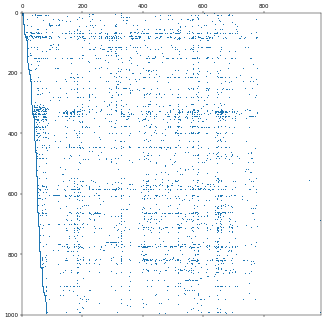

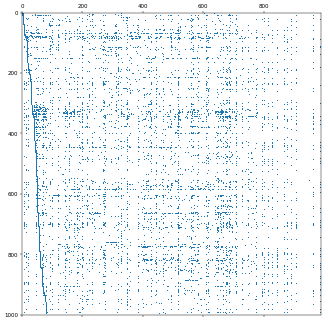

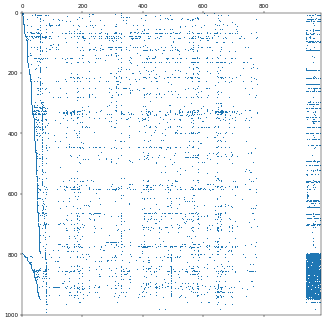

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 40
plt.rcParams['figure.figsize'] = [10, 10]

print(len(M.data))
print(len(N.data))


def sortM(trueA, trueB, M):
    trueA.sort()
    trueB.sort()
    m, n = M.shape
    
    row_index = np.arange(m)
    swap_index = m -1
    for index in range(len(trueA)):
        row_index[swap_index] = trueA[len(trueA) -1 - index]
        row_index[trueA[len(trueA) -1 - index]] = swap_index
        
        swap_index -=1
    
    col_index = np.arange(n)
    swap_index = n -1
    for index in range(len(trueB)):
        col_index[swap_index] = trueB[len(trueB) -1 - index]
        col_index[trueB[len(trueB) -1 - index]] = swap_index
        
        swap_index -=1
        
    x = M.tocoo()
    idenRows = np.asarray(row_index, dtype=x.row.dtype)
    x.row = idenRows[x.row]
    
    idenCols = np.asarray(col_index, dtype=x.col.dtype)
    x.col = idenCols[x.col]
    
    H = x.tocsr()
    return H

plt.spy(N, marker=',', markersize = 5)
plt.show()

plt.spy(M, marker=',', markersize = 5)
plt.show()

MM = sortM(trueA, trueB, M)
plt.spy(MM, marker=',', markersize = 5)
plt.show()

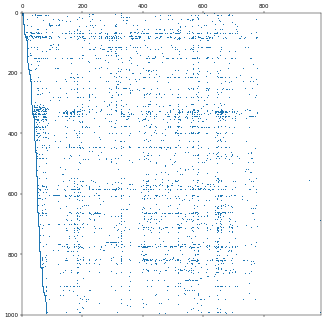

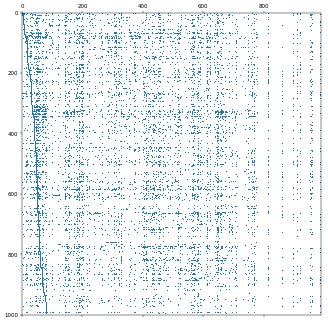

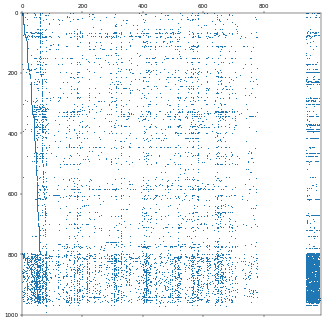

In [11]:
plt.spy(NR, marker=',', markersize = 5)
plt.show()

plt.spy(MR, marker=',', markersize = 5)
plt.show()

MM = sortM(trueAR, trueBR, MR)
plt.spy(MM, marker=',', markersize = 5)
plt.show()